# Udacity Self-Driving Car Engineer Nanodegree Program
## Vehicle Detection Project

The goals / steps of this project are the following:

* Performing a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a Linear SVM classifier
    * Optionally, applying a color transform and appending binned color features, as well as histograms of color, to the HOG feature vector. 
    * Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implementing a sliding-window technique and using the trained classifier to search for vehicles in images.
* Running the pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and creating a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimating a bounding box for vehicles detected.

# 1. Modules to import

In [72]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog
from scipy.ndimage.measurements import label

# 2. Class to load and train data, and detecting vehicles

In [82]:
class VehicleDetect:
    def __init__(self):
        self.cars = None
        self.nonCars = None
        self.X = None
        self.y = None
        self.X_train = None
        self.y_train = None
        self.svc = LinearSVC()
        self.prev_rects = []
        
        
    def load_data(self):
        self.cars = glob.glob('./training/vehicles/**/*.png')
        self.nonCars = glob.glob('./training/non-vehicles/**/*.png')
        print('Data loaded...')
        print('Cars: ', len(self.cars))
        print('Non-cars: ', len(self.nonCars))
    
    def random_images(self, rows, cols):
        fig, axs = plt.subplots(rows, cols, figsize=(rows*2, cols*2))
        fig.subplots_adjust(hspace = .2, wspace=.001)
        axs = axs.ravel()

        for i in range(0,int(rows*cols)):
            j = np.random.randint(0,2)
            if j==0:
                img = cv2.imread(self.cars[np.random.randint(0,len(self.cars))])
                axs[i].set_title('car', fontsize=10)
            else:
                img = cv2.imread(self.nonCars[np.random.randint(0,len(self.nonCars))])
                axs[i].set_title('Not a car', fontsize=10)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            axs[i].axis('off')
            axs[i].imshow(img)
    
    def get_hog_features(self, img, orient, pix_per_cell, cell_per_block, 
                        visualize=False, feature_vec=True):
        if visualize == True:
            features, hog_image = hog(img, orientations=orient, 
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), 
                                      transform_sqrt=False, 
                                      visualise=visualize, feature_vector=feature_vec)
            return features, hog_image
        else:      
            features = hog(img, orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), 
                           transform_sqrt=False, 
                           visualise=visualize, feature_vector=feature_vec)
            return features
    
    
    def visualize_img_hog_features(self, img, ax1, ax2, title):
        _, dst = self.get_hog_features(img[:,:,2], 9, 8, 8, visualize=True, feature_vec=True)
        ax1.imshow(img)
        ax1.set_title(title, fontsize=16)
        ax1.axis('off')
        ax2.imshow(dst, cmap='gray')
        ax2.set_title('HOG', fontsize=16)
        ax2.axis('off')
        
    def visualize_hog(self):
        f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(8, 4))
        f.subplots_adjust(hspace = .2, wspace=.001)
        
        img = cv2.imread(self.cars[np.random.randint(0,len(self.cars))])
        self.visualize_img_hog_features(img, ax1, ax2, 'Car')
        img = cv2.imread(self.nonCars[np.random.randint(0,len(self.nonCars))])
        self.visualize_img_hog_features(img, ax3, ax4, 'Not a car')
        
        img = cv2.imread(self.cars[np.random.randint(0,len(self.cars))])
        self.visualize_img_hog_features(img, ax5, ax6, 'Car')
        img = cv2.imread(self.nonCars[np.random.randint(0,len(self.nonCars))])
        self.visualize_img_hog_features(img, ax7, ax8, 'Not a car')
 
    def convert_color_space(self, img, cspace='RGB'):
        if cspace != 'RGB':
            if cspace == 'HSV':
                image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            image = np.copy(img)
        return image        

    def extract_features(self, imgs, cspace='RGB', orient=9, 
                         pix_per_cell=8, cell_per_block=2, hog_channel=0):
        # Create a list to append feature vectors to
        features = []
        # Iterate through the list of images
        for file in imgs:
            # Read in each one by one
            image = mpimg.imread(file)
            # apply color conversion if other than 'RGB'
            
            feature_image = self.convert_color_space(image, cspace)

            # Call get_hog_features() with visualize=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(self.get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        visualize=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = self.get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                     pix_per_cell, cell_per_block, visualize=False, feature_vec=True)
            # Append the new feature vector to the features list
            features.append(hog_features)
        # Return list of feature vectors
        return features

    def extract_training_features(self, params=None):
        # Feature extraction parameters
        if params is None:
            colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
            orient = 11
            pix_per_cell = 16
            cell_per_block = 2
            hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
        else:
            colorspace = params['cspace'] # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
            orient = params['orient']
            pix_per_cell = params['pix_per_cell']
            cell_per_block = params['cell_per_block']
            hog_channel = params['hog_channel'] # Can be 0, 1, 2, or "ALL"

        t = time.time()    
        car_features = self.extract_features(self.cars, cspace=colorspace, orient=orient, 
                                             pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                             hog_channel=hog_channel)
        noncar_features = self.extract_features(self.nonCars, cspace=colorspace, orient=orient, 
                                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                                hog_channel=hog_channel)
        t2 = time.time()
        tt = round(t2-t, 2)
        return car_features, noncar_features, tt
    
    def make_training_data(self, params=None):
        car_features, noncar_features, tt = self.extract_training_features(params)
        
        self.X = np.vstack((car_features, noncar_features)).astype(np.float64)
        self.y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, 
                                                                                random_state=np.random.randint(0, 100))
        
        print(tt, 'Seconds to extract features...')
        print('Train data shape: ', self.X_train.shape)
        print('Test data shape: ', self.X_test.shape)
        
    def make_training_data_for_exploration(self, params=None):
        car_features, noncar_features, tt = self.extract_training_features(params)
        
        self.X = np.vstack((car_features, noncar_features)).astype(np.float64)
        self.y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2, 
                                                                                random_state=np.random.randint(0, 100))      
        return car_features, noncar_features, tt
    
    def train_for_exploration(self):
        # Check the training time for the SVC
        t = time.time()
        self.svc.fit(self.X_train, self.y_train)
        t2 = time.time()        
        return round(t2-t, 2), round(self.svc.score(self.X_test, self.y_test), 4)
    
    def train(self):
        # Check the training time for the SVC
        t = time.time()
        self.svc.fit(self.X_train, self.y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(self.svc.score(self.X_test, self.y_test), 4))
        
    def predict_example(self, n=None):
        if n is None:
            n_predict = 20
        else:
            n_predict = n
        t=time.time()
        print('SVC predicts : ', self.svc.predict(self.X_test[0:n_predict]))
        print('Actual labels: ', self.y_test[0:n_predict])
        t2 = time.time()
        print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
        
    
    ###########################################################################
    # Here is your draw_boxes function from the previous exercise
    def draw_boxes(self, img, bboxes, color=(0, 0, 255), thick=6):
        # Make a copy of the image
        imcopy = np.copy(img)
        random_color = False
        # Iterate through the bounding boxes
        for bbox in bboxes:
            if color == 'random' or random_color:
                color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
                random_color = True
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        # Return the image copy with boxes drawn
        return imcopy
    ###########################################################################
    
    
    def find_cars(self, img, ystart, ystop, scale, cspace, hog_channel, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
        # array of rectangles where cars were detected
        rectangles = []

        img = img.astype(np.float32)/255.0

        img_tosearch = img[ystart:ystop,:,:]

        # apply color conversion if other than 'RGB'
        ctrans_tosearch = self.convert_color_space(img_tosearch, cspace)

        # rescale image if other than 1.0 scale
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        # select colorspace channel for HOG 
        if hog_channel == 'ALL':
            ch1 = ctrans_tosearch[:,:,0]
            ch2 = ctrans_tosearch[:,:,1]
            ch3 = ctrans_tosearch[:,:,2]
        else: 
            ch1 = ctrans_tosearch[:,:,hog_channel]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
        nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
        nfeat_per_block = orient*cell_per_block**2
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = self.get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
        if hog_channel == 'ALL':
            hog2 = self.get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog3 = self.get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
                if hog_channel == 'ALL':
                    hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                else:
                    hog_features = hog_feat1

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                test_prediction = self.svc.predict(hog_features.reshape(1,-1))

                if test_prediction == 1 or show_all_rectangles:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

        return rectangles
    
    def update_heatmap(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        hmap = np.copy(heatmap)
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            hmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        # Return updated heatmap
        return hmap

    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0
        # Return thresholded map
        return heatmap
    
    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        rects = []
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            rects.append(bbox)
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        # Return the image and final rectangles
        return img, rects
    
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]
    
    
    def potential_search_areas(self, img, params, show_all=True):
        rects = []
        for i in range(len(params)):
            rects.append(self.find_cars(img, params[i]['ystart'], params[i]['ystop'], params[i]['scale'], 
                                        params[i]['colorspace'], params[i]['hog_channel'], None, 
                                        params[i]['orient'], params[i]['pix_per_cell'], 
                                        params[i]['cell_per_block'], None, None, 
                                        show_all_rectangles=show_all))

        rectangles = [item for sublist in rects for item in sublist] 
        test_img_rects = self.draw_boxes(img, rectangles, color='random', thick=2)

        return test_img_rects, rectangles, len(rectangles)
        
    
    def process_frame(self, img, video=True):
        rectangles = []
        params = {
            0 : {'ystart':400, 'ystop':464, 'scale':1.0},
            1 : {'ystart':400, 'ystop':496, 'scale':1.5},
            2 : {'ystart':400, 'ystop':528, 'scale':2.0},
            3 : {'ystart':400, 'ystop':592, 'scale':3.5},            
            4 : {'ystart':416, 'ystop':480, 'scale':1.0},
            5 : {'ystart':432, 'ystop':528, 'scale':1.5},
            6 : {'ystart':432, 'ystop':560, 'scale':2.0},
            7 : {'ystart':464, 'ystop':660, 'scale':3.5}
        }
        
        colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        orient = 11
        pix_per_cell = 16
        cell_per_block = 2
        hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
        
        for i in range(8):
            rectangles.append(self.find_cars(img, 
                                             params[i]['ystart'], params[i]['ystop'], params[i]['scale'], 
                                             colorspace, hog_channel, None, orient, pix_per_cell, cell_per_block, None, None))
        rectangles = [item for sublist in rectangles for item in sublist] 

        if video is False:
            heatmap_img = np.zeros_like(img[:,:,0])
            heatmap_img = self.update_heatmap(heatmap_img, rectangles)
            heatmap_img = self.apply_threshold(heatmap_img, 1)
            labels = label(heatmap_img)
            draw_img, rects = self.draw_labeled_bboxes(np.copy(img), labels)
        else:  
            # add detections to the history
            if len(rectangles) > 0:
                self.add_rects(rectangles)

            heatmap_img = np.zeros_like(img[:,:,0])
            for rect_set in self.prev_rects:
                heatmap_img = self.update_heatmap(heatmap_img, rect_set)
            heatmap_img = self.apply_threshold(heatmap_img, 1 + len(self.prev_rects)//2)

            labels = label(heatmap_img)
            draw_img, rect = self.draw_labeled_bboxes(np.copy(img), labels)
        return draw_img
        

# 3. Load data and visualize random images

Data loaded...
Cars:  8792
Non-cars:  8968


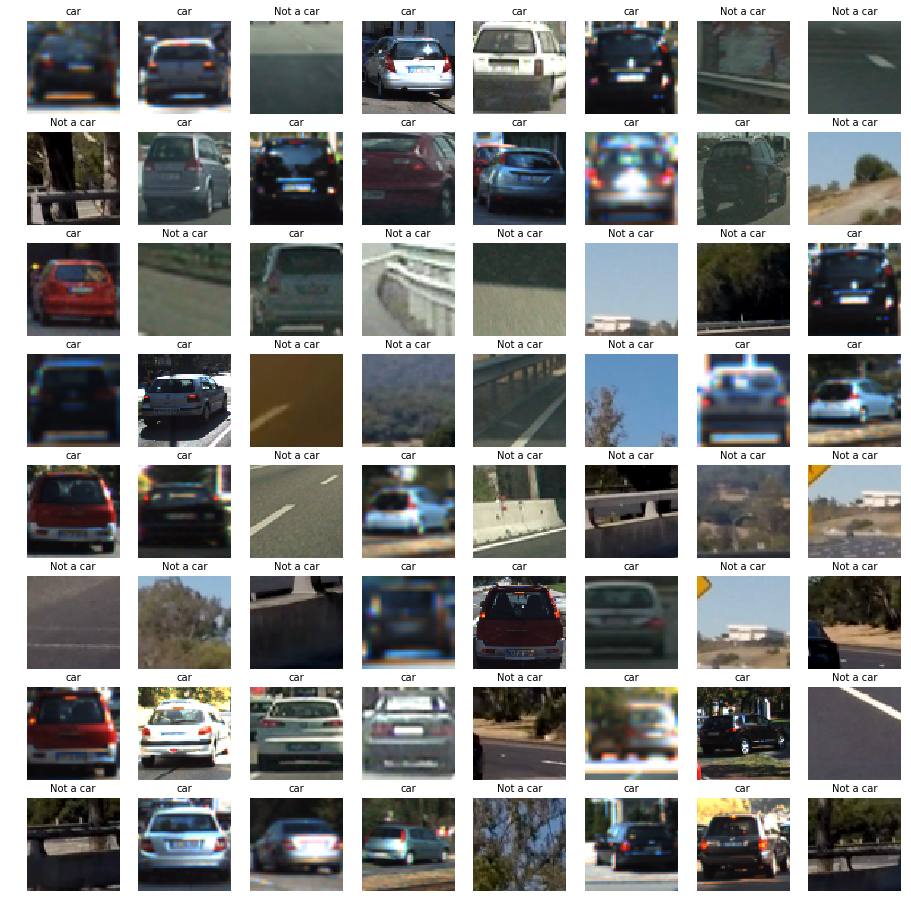

In [83]:
d = VehicleDetect()
d.load_data()
d.random_images(8,8)

# 4. Visualize HOG features

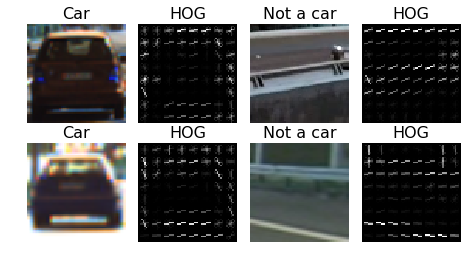

In [84]:
d.visualize_hog()

# 5. Extract features, define labels, shuffle and split

## 5.1. Exploring parameters

In [ ]:
"""
# Commented since this part of the code will take some time

colorspaces = ['HLS', 'HSV', 'LUV', 'RGB', 'YCrCb', 'YUV']
orientations = [9,10,11]
hog_channels = [0, 1, 2, 'ALL']
pixels_per_cell = [8, 16]
cells_per_block = [2]

i = 1

for cspace in colorspaces:
    for orient in orientations:
        for hog_channel in hog_channels:
            for pix_per_cell in pixels_per_cell:
                for cell_per_block in cells_per_block:
                    params = {
                        'cspace': cspace, 
                        'orient': orient, 
                        'hog_channel': hog_channel, 
                        'pix_per_cell': pix_per_cell,
                        'cell_per_block': cell_per_block
                    }
                    
                    a, b, tt = d.make_training_data_for_exploration(params)
                    train_time, accuracy = d.train_for_exploration()

                    print('|', i,'|', cspace,'|', hog_channel, '|',orient,'|', pix_per_cell, '|', 
                          cell_per_block, '|', tt, '|', np.array(a).shape[1], '|', train_time, '|', accuracy, '|')
                    i = i+1
"""

## 5.2. HOG parameters

| Index | Colorspace |  HOG Channel |Orientations | Pixels Per Cell | Cells Per Block | Extract Time | Vector size | Training time | Accuracy |
| :-----------------: | :--------: | :----------: | :-------------: | :-------------: | :---------: | :------------:|:------------:|:------------:|:------------:|
| 1 | HLS | 0 | 9 | 8 | 2 | 24.61 | 1764 | 5.02 | 0.9226 |
| 2 | HLS | 0 | 9 | 16 | 2 | 35.1 | 324 | 0.51 | 0.9119 |
| 3 | HLS | 1 | 9 | 8 | 2 | 40.38 | 1764 | 3.71 | 0.9679 |
| 4 | HLS | 1 | 9 | 16 | 2 | 30.29 | 324 | 0.47 | 0.9499 |
| 5 | HLS | 2 | 9 | 8 | 2 | 37.13 | 1764 | 5.99 | 0.9088 |
| 6 | HLS | 2 | 9 | 16 | 2 | 29.44 | 324 | 0.49 | 0.8801 |
| 7 | HLS | ALL | 9 | 8 | 2 | 89.63 | 5292 | 7.77 | 0.9854 |
| 8 | HLS | ALL | 9 | 16 | 2 | 78.67 | 972 | 1.28 | 0.9766 |
| 9 | HLS | 0 | 10 | 8 | 2 | 26.55 | 1960 | 3.89 | 0.9398 |
| 10 | HLS | 0 | 10 | 16 | 2 | 32.94 | 360 | 0.41 | 0.9189 |
| 11 | HLS | 1 | 10 | 8 | 2 | 37.07 | 1960 | 3.54 | 0.955 |
| 12 | HLS | 1 | 10 | 16 | 2 | 28.01 | 360 | 0.51 | 0.9428 |
| 13 | HLS | 2 | 10 | 8 | 2 | 33.66 | 1960 | 5.22 | 0.9116 |
| 14 | HLS | 2 | 10 | 16 | 2 | 28.56 | 360 | 0.47 | 0.8801 |
| 15 | HLS | ALL | 10 | 8 | 2 | 85.3 | 5880 | 7.23 | 0.9837 |
| 16 | HLS | ALL | 10 | 16 | 2 | 87.69 | 1080 | 0.85 | 0.978 |
| 17 | HLS | 0 | 11 | 8 | 2 | 24.67 | 2156 | 4.62 | 0.9274 |
| 18 | HLS | 0 | 11 | 16 | 2 | 18.44 | 396 | 0.59 | 0.9133 |
| 19 | HLS | 1 | 11 | 8 | 2 | 24.4 | 2156 | 3.9 | 0.964 |
| 20 | HLS | 1 | 11 | 16 | 2 | 18.09 | 396 | 0.45 | 0.9485 |
| 21 | HLS | 2 | 11 | 8 | 2 | 24.86 | 2156 | 5.46 | 0.9093 |
| 22 | HLS | 2 | 11 | 16 | 2 | 17.8 | 396 | 0.65 | 0.8789 |
| 23 | HLS | ALL | 11 | 8 | 2 | 63.65 | 6468 | 8.26 | 0.9783 |
| 24 | HLS | ALL | 11 | 16 | 2 | 43.03 | 1188 | 1.41 | 0.9755 |
| 25 | HSV | 0 | 9 | 8 | 2 | 24.67 | 1764 | 4.92 | 0.9358 |
| 26 | HSV | 0 | 9 | 16 | 2 | 29.22 | 324 | 0.53 | 0.9144 |
| 27 | HSV | 1 | 9 | 8 | 2 | 35.24 | 1764 | 4.82 | 0.9155 |
| 28 | HSV | 1 | 9 | 16 | 2 | 27.14 | 324 | 0.46 | 0.8986 |
| 29 | HSV | 2 | 9 | 8 | 2 | 31.98 | 1764 | 3.46 | 0.9597 |
| 30 | HSV | 2 | 9 | 16 | 2 | 25.81 | 324 | 0.46 | 0.9403 |
| 31 | HSV | ALL | 9 | 8 | 2 | 73.91 | 5292 | 7.34 | 0.9851 |
| 32 | HSV | ALL | 9 | 16 | 2 | 58.42 | 972 | 0.93 | 0.9794 |
| 33 | HSV | 0 | 10 | 8 | 2 | 23.96 | 1960 | 3.57 | 0.9367 |
| 34 | HSV | 0 | 10 | 16 | 2 | 30.36 | 360 | 0.39 | 0.931 |
| 35 | HSV | 1 | 10 | 8 | 2 | 35.57 | 1960 | 4.65 | 0.9195 |
| 36 | HSV | 1 | 10 | 16 | 2 | 28.91 | 360 | 0.5 | 0.8956 |
| 37 | HSV | 2 | 10 | 8 | 2 | 34.66 | 1960 | 3.63 | 0.962 |
| 38 | HSV | 2 | 10 | 16 | 2 | 25.04 | 360 | 0.49 | 0.9457 |
| 39 | HSV | ALL | 10 | 8 | 2 | 81.57 | 5880 | 7.33 | 0.9831 |
| 40 | HSV | ALL | 10 | 16 | 2 | 67.59 | 1080 | 0.84 | 0.982 |
| 41 | HSV | 0 | 11 | 8 | 2 | 25.22 | 2156 | 5.07 | 0.9412 |
| 42 | HSV | 0 | 11 | 16 | 2 | 18.73 | 396 | 0.59 | 0.9203 |
| 43 | HSV | 1 | 11 | 8 | 2 | 25.1 | 2156 | 4.71 | 0.911 |
| 44 | HSV | 1 | 11 | 16 | 2 | 19.2 | 396 | 0.64 | 0.8947 |
| 45 | HSV | 2 | 11 | 8 | 2 | 24.42 | 2156 | 3.78 | 0.962 |
| 46 | HSV | 2 | 11 | 16 | 2 | 18.34 | 396 | 0.45 | 0.9513 |
| 47 | HSV | ALL | 11 | 8 | 2 | 63.63 | 6468 | 7.53 | 0.984 |
| 48 | HSV | ALL | 11 | 16 | 2 | 43.43 | 1188 | 1.27 | 0.9786 |
| 49 | LUV | 0 | 9 | 8 | 2 | 24.69 | 1764 | 3.75 | 0.9617 |
| 50 | LUV | 0 | 9 | 16 | 2 | 30.72 | 324 | 0.37 | 0.942 |
| 51 | LUV | 1 | 9 | 8 | 2 | 36.66 | 1764 | 3.88 | 0.9367 |
| 52 | LUV | 1 | 9 | 16 | 2 | 24.75 | 324 | 0.44 | 0.9279 |
| 53 | LUV | 2 | 9 | 8 | 2 | 30.49 | 1764 | 4.61 | 0.9167 |
| 54 | LUV | 2 | 9 | 16 | 2 | 26.22 | 324 | 0.46 | 0.9127 |
| 55 | LUV | ALL | 9 | 8 | 2 | 82.5 | 5292 | 9.57 | 0.9764 |
| 56 | LUV | ALL | 9 | 16 | 2 | 70.35 | 972 | 1.15 | 0.9772 |
| 57 | LUV | 0 | 10 | 8 | 2 | 26.95 | 1960 | 3.71 | 0.9572 |
| 58 | LUV | 0 | 10 | 16 | 2 | 30.41 | 360 | 0.44 | 0.9451 |
| 59 | LUV | 1 | 10 | 8 | 2 | 36.09 | 1960 | 3.84 | 0.9341 |
| 60 | LUV | 1 | 10 | 16 | 2 | 26.1 | 360 | 0.42 | 0.9181 |
| 61 | LUV | 2 | 10 | 8 | 2 | 30.21 | 1960 | 4.36 | 0.9268 |
| 62 | LUV | 2 | 10 | 16 | 2 | 26.18 | 360 | 0.42 | 0.9009 |
| 63 | LUV | ALL | 10 | 8 | 2 | 80.95 | 5880 | 9.67 | 0.9764 |
| 64 | LUV | ALL | 10 | 16 | 2 | 73.48 | 1080 | 1.01 | 0.9727 |
| 65 | LUV | 0 | 11 | 8 | 2 | 24.84 | 2156 | 3.87 | 0.9595 |
| 66 | LUV | 0 | 11 | 16 | 2 | 18.32 | 396 | 0.57 | 0.951 |
| 67 | LUV | 1 | 11 | 8 | 2 | 25.57 | 2156 | 3.88 | 0.9465 |
| 68 | LUV | 1 | 11 | 16 | 2 | 18.98 | 396 | 0.5 | 0.9231 |
| 69 | LUV | 2 | 11 | 8 | 2 | 24.57 | 2156 | 4.47 | 0.9245 |
| 70 | LUV | 2 | 11 | 16 | 2 | 19.02 | 396 | 0.6 | 0.9048 |
| 71 | LUV | ALL | 11 | 8 | 2 | 62.58 | 6468 | 7.91 | 0.9806 |
| 72 | LUV | ALL | 11 | 16 | 2 | 44.07 | 1188 | 1.32 | 0.9752 |
| 73 | RGB | 0 | 9 | 8 | 2 | 23.43 | 1764 | 3.81 | 0.9595 |
| 74 | RGB | 0 | 9 | 16 | 2 | 18.26 | 324 | 0.53 | 0.9412 |
| 75 | RGB | 1 | 9 | 8 | 2 | 24.3 | 1764 | 3.29 | 0.962 |
| 76 | RGB | 1 | 9 | 16 | 2 | 20.86 | 324 | 0.48 | 0.9496 |
| 77 | RGB | 2 | 9 | 8 | 2 | 26.78 | 1764 | 3.36 | 0.9561 |
| 78 | RGB | 2 | 9 | 16 | 2 | 21.07 | 324 | 0.41 | 0.951 |
| 79 | RGB | ALL | 9 | 8 | 2 | 70.33 | 5292 | 20.16 | 0.9733 |
| 80 | RGB | ALL | 9 | 16 | 2 | 53.87 | 972 | 2.19 | 0.9699 |
| 81 | RGB | 0 | 10 | 8 | 2 | 23.9 | 1960 | 3.42 | 0.9513 |
| 82 | RGB | 0 | 10 | 16 | 2 | 23.36 | 360 | 0.59 | 0.9409 |
| 83 | RGB | 1 | 10 | 8 | 2 | 28.49 | 1960 | 3.38 | 0.9657 |
| 84 | RGB | 1 | 10 | 16 | 2 | 22.84 | 360 | 0.51 | 0.9516 |
| 85 | RGB | 2 | 10 | 8 | 2 | 28.61 | 1960 | 3.3 | 0.9578 |
| 86 | RGB | 2 | 10 | 16 | 2 | 24.08 | 360 | 0.47 | 0.9462 |
| 87 | RGB | ALL | 10 | 8 | 2 | 78.61 | 5880 | 14.86 | 0.9654 |
| 88 | RGB | ALL | 10 | 16 | 2 | 72.31 | 1080 | 2.26 | 0.9628 |
| 89 | RGB | 0 | 11 | 8 | 2 | 23.31 | 2156 | 3.94 | 0.9611 |
| 90 | RGB | 0 | 11 | 16 | 2 | 17.25 | 396 | 0.62 | 0.9403 |
| 91 | RGB | 1 | 11 | 8 | 2 | 23.21 | 2156 | 3.43 | 0.9642 |
| 92 | RGB | 1 | 11 | 16 | 2 | 17.03 | 396 | 0.54 | 0.9516 |
| 93 | RGB | 2 | 11 | 8 | 2 | 23.33 | 2156 | 3.53 | 0.9617 |
| 94 | RGB | 2 | 11 | 16 | 2 | 17.16 | 396 | 0.58 | 0.9555 |
| 95 | RGB | ALL | 11 | 8 | 2 | 60.35 | 6468 | 13.54 | 0.9702 |
| 96 | RGB | ALL | 11 | 16 | 2 | 40.98 | 1188 | 2.54 | 0.9654 |
| 97 | YCrCb | 0 | 9 | 8 | 2 | 22.94 | 1764 | 3.58 | 0.9693 |
| 98 | YCrCb | 0 | 9 | 16 | 2 | 22.96 | 324 | 0.38 | 0.9465 |
| 99 | YCrCb | 1 | 9 | 8 | 2 | 28.62 | 1764 | 3.61 | 0.9476 |
| 100 | YCrCb | 1 | 9 | 16 | 2 | 23.64 | 324 | 0.39 | 0.9358 |
| 101 | YCrCb | 2 | 9 | 8 | 2 | 30.16 | 1764 | 4.09 | 0.933 |
| 102 | YCrCb | 2 | 9 | 16 | 2 | 24.22 | 324 | 0.43 | 0.9248 |
| 103 | YCrCb | ALL | 9 | 8 | 2 | 77.76 | 5292 | 6.49 | 0.9786 |
| 104 | YCrCb | ALL | 9 | 16 | 2 | 62.76 | 972 | 0.91 | 0.9797 |
| 105 | YCrCb | 0 | 10 | 8 | 2 | 25.16 | 1960 | 3.33 | 0.9597 |
| 106 | YCrCb | 0 | 10 | 16 | 2 | 25.06 | 360 | 0.47 | 0.9428 |
| 107 | YCrCb | 1 | 10 | 8 | 2 | 30.9 | 1960 | 3.09 | 0.9462 |
| 108 | YCrCb | 1 | 10 | 16 | 2 | 24.81 | 360 | 0.35 | 0.9459 |
| 109 | YCrCb | 2 | 10 | 8 | 2 | 29.77 | 1960 | 3.75 | 0.944 |
| 110 | YCrCb | 2 | 10 | 16 | 2 | 25.17 | 360 | 0.4 | 0.9268 |
| 111 | YCrCb | ALL | 10 | 8 | 2 | 74.08 | 5880 | 6.22 | 0.984 |
| 112 | YCrCb | ALL | 10 | 16 | 2 | 69.38 | 1080 | 0.8 | 0.9825 |
| 113 | YCrCb | 0 | 11 | 8 | 2 | 23.56 | 2156 | 3.69 | 0.9614 |
| 114 | YCrCb | 0 | 11 | 16 | 2 | 17.33 | 396 | 0.54 | 0.9561 |
| 115 | YCrCb | 1 | 11 | 8 | 2 | 24.02 | 2156 | 3.46 | 0.9476 |
| 116 | YCrCb | 1 | 11 | 16 | 2 | 18.28 | 396 | 0.47 | 0.9344 |
| 117 | YCrCb | 2 | 11 | 8 | 2 | 24.44 | 2156 | 4.28 | 0.9358 |
| 118 | YCrCb | 2 | 11 | 16 | 2 | 17.57 | 396 | 0.49 | 0.9288 |
| 119 | YCrCb | ALL | 11 | 8 | 2 | 61.37 | 6468 | 6.6 | 0.987 |
| 120 | YCrCb | ALL | 11 | 16 | 2 | 42.22 | 1188 | 1.02 | 0.98 |
| 121 | YUV | 0 | 9 | 8 | 2 | 23.06 | 1764 | 3.65 | 0.9651 |
| 122 | YUV | 0 | 9 | 16 | 2 | 24.22 | 324 | 0.48 | 0.9499 |
| 123 | YUV | 1 | 9 | 8 | 2 | 31.16 | 1764 | 3.84 | 0.9313 |
| 124 | YUV | 1 | 9 | 16 | 2 | 23.84 | 324 | 0.41 | 0.924 |
| 125 | YUV | 2 | 9 | 8 | 2 | 30.36 | 1764 | 3.65 | 0.9496 |
| 126 | YUV | 2 | 9 | 16 | 2 | 24.29 | 324 | 0.39 | 0.9299 |
| 127 | YUV | ALL | 9 | 8 | 2 | 76.82 | 5292 | 7.23 | 0.9806 |
| 128 | YUV | ALL | 9 | 16 | 2 | 62.6 | 972 | 0.9 | 0.9817 |
| 129 | YUV | 0 | 10 | 8 | 2 | 25.89 | 1960 | 3.73 | 0.9609 |
| 130 | YUV | 0 | 10 | 16 | 2 | 24.83 | 360 | 0.51 | 0.9448 |
| 131 | YUV | 1 | 10 | 8 | 2 | 29.94 | 1960 | 3.57 | 0.9369 |
| 132 | YUV | 1 | 10 | 16 | 2 | 24.79 | 360 | 0.39 | 0.9274 |
| 133 | YUV | 2 | 10 | 8 | 2 | 29.83 | 1960 | 3.29 | 0.9538 |
| 134 | YUV | 2 | 10 | 16 | 2 | 24.63 | 360 | 0.36 | 0.9437 |
| 135 | YUV | ALL | 10 | 8 | 2 | 83.18 | 5880 | 7.99 | 0.9834 |
| 136 | YUV | ALL | 10 | 16 | 2 | 81.36 | 1080 | 0.83 | 0.9825 |
| 137 | YUV | 0 | 11 | 8 | 2 | 23.35 | 2156 | 3.58 | 0.9642 |
| 138 | YUV | 0 | 11 | 16 | 2 | 17.5 | 396 | 0.56 | 0.949 |
| 139 | YUV | 1 | 11 | 8 | 2 | 24.38 | 2156 | 4.1 | 0.9338 |
| 140 | YUV | 1 | 11 | 16 | 2 | 17.5 | 396 | 0.47 | 0.9299 |
| 141 | YUV | 2 | 11 | 8 | 2 | 23.94 | 2156 | 3.54 | 0.9437 |
| 142 | YUV | 2 | 11 | 16 | 2 | 17.49 | 396 | 0.45 | 0.9459 |
| 143 | YUV | ALL | 11 | 8 | 2 | 60.23 | 6468 | 6.33 | 0.982 |
| 144 | YUV | ALL | 11 | 16 | 2 | 41.84 | 1188 | 0.97 | 0.9803 |

## 5.3. Choice of parameters

We consider the following parameters to optimize time for feature extraction and training as well as test accuracy

In [90]:
params = {
    'cspace': 'YUV', 
    'orient': 11, 
    'pix_per_cell': 16, 
    'cell_per_block': 2, 
    'hog_channel': 'ALL'
}

## 5.4. Preparing training data 

In [91]:
d.make_training_data(params)

42.97 Seconds to extract features...
Train data shape:  (14208, 1188)
Test data shape:  (3552, 1188)


# 6. Train classifier

In [92]:
d.train()
d.predict_example(15)

1.09 Seconds to train SVC...
Test Accuracy of SVC =  0.9856
SVC predicts :  [ 0.  0.  0.  1.  0.  1.  1.  1.  0.  0.  1.  1.  1.  0.  0.]
Actual labels:  [ 0.  0.  0.  1.  0.  1.  1.  1.  0.  0.  1.  1.  1.  0.  0.]
0.00601 Seconds to predict 15 labels with SVC


## 6.1. Test detecting cars on an image

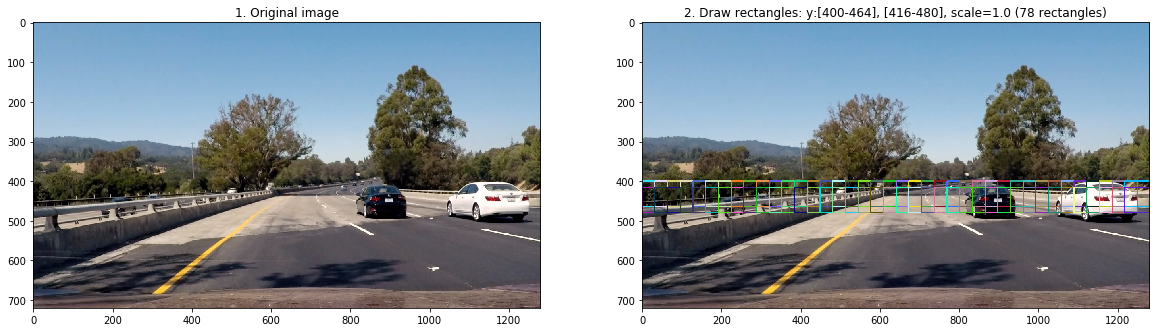

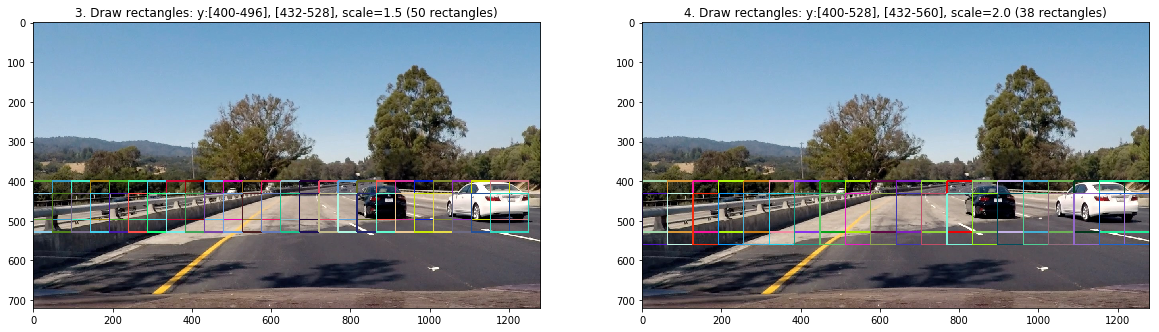

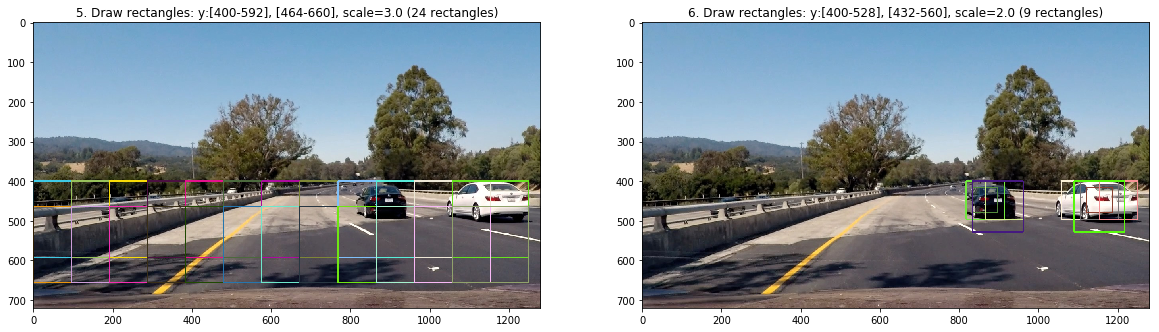

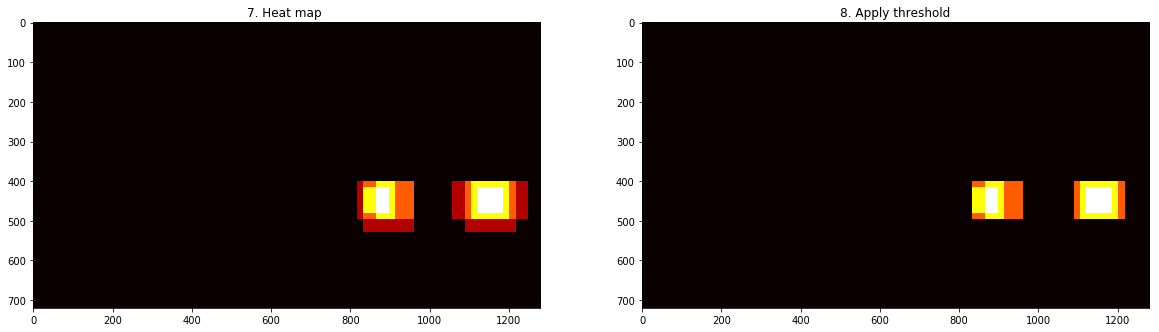

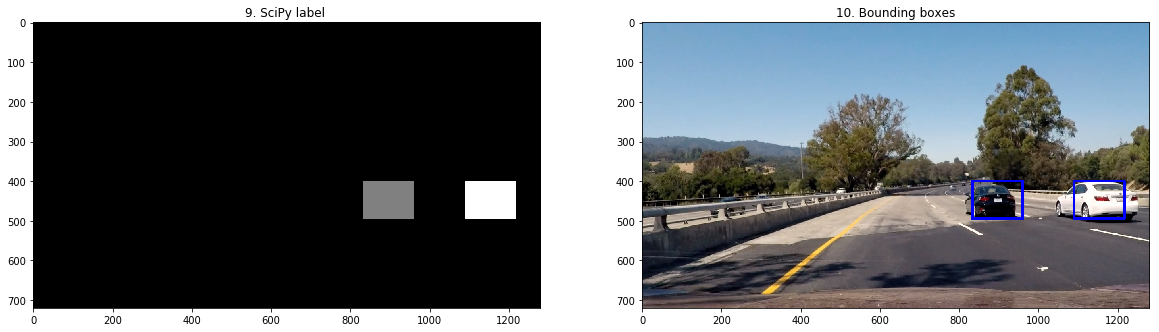

In [93]:
test_img = mpimg.imread('./test_images/test4.jpg')

ystart = 400
ystop = 656
scale = 1.5

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('1. Original image')
ax1.imshow(test_img)

params={
    0:{'ystart':400,'ystop':464,'scale':1.0, 'colorspace':'YUV', 'hog_channel':'ALL', 
       'orient':11, 'pix_per_cell':16,'cell_per_block':2}, 
    1:{'ystart':416,'ystop':480, 'scale':1.0, 'colorspace':'YUV', 'hog_channel':'ALL', 
       'orient':11, 'pix_per_cell':16,'cell_per_block':2}
}
img, rects, t = d.potential_search_areas(test_img, params)
ax2.set_title('2. Draw rectangles: y:[400-464], [416-480], scale=1.0 (' + str(t) + ' rectangles)')
ax2.imshow(img)


f, (ax3, ax4) = plt.subplots(1, 2, figsize=(20,10))
params={
    0:{'ystart':400,'ystop':496,'scale':1.5, 'colorspace':'YUV', 'hog_channel':'ALL', 
       'orient':11, 'pix_per_cell':16,'cell_per_block':2}, 
    1:{'ystart':432,'ystop':528, 'scale':1.5, 'colorspace':'YUV', 'hog_channel':'ALL', 
       'orient':11, 'pix_per_cell':16,'cell_per_block':2}
}
img, rects, t = d.potential_search_areas(test_img, params)
ax3.set_title('3. Draw rectangles: y:[400-496], [432-528], scale=1.5 (' + str(t) + ' rectangles)')
ax3.imshow(img)

params={
    0:{'ystart':400,'ystop':528,'scale':2.0, 'colorspace':'YUV', 'hog_channel':'ALL', 
       'orient':11, 'pix_per_cell':16,'cell_per_block':2}, 
    1:{'ystart':432,'ystop':560, 'scale':2.0, 'colorspace':'YUV', 'hog_channel':'ALL', 
       'orient':11, 'pix_per_cell':16,'cell_per_block':2}
}
img, rects, t = d.potential_search_areas(test_img, params)
ax4.set_title('4. Draw rectangles: y:[400-528], [432-560], scale=2.0 (' + str(t) + ' rectangles)')
ax4.imshow(img)

f, (ax5, ax6) = plt.subplots(1, 2, figsize=(20,10))
params={
    0:{'ystart':400,'ystop':592,'scale':3.0, 'colorspace':'YUV', 'hog_channel':'ALL', 
       'orient':11, 'pix_per_cell':16,'cell_per_block':2}, 
    1:{'ystart':464,'ystop':660, 'scale':3.0, 'colorspace':'YUV', 'hog_channel':'ALL', 
       'orient':11, 'pix_per_cell':16,'cell_per_block':2}
}
img, rects, t = d.potential_search_areas(test_img, params)
ax5.set_title('5. Draw rectangles: y:[400-592], [464-660], scale=3.0 (' + str(t) + ' rectangles)')
ax5.imshow(img)

params={
        0:{'ystart':400,'ystop':464,'scale':1.0, 'colorspace':'YUV', 'hog_channel':'ALL', 
       'orient':11, 'pix_per_cell':16,'cell_per_block':2}, 
        1:{'ystart':416,'ystop':480, 'scale':1.0, 'colorspace':'YUV', 'hog_channel':'ALL', 
       'orient':11, 'pix_per_cell':16,'cell_per_block':2},
        2:{'ystart':400,'ystop':496,'scale':1.5, 'colorspace':'YUV', 'hog_channel':'ALL', 
       'orient':11, 'pix_per_cell':16,'cell_per_block':2}, 
        3:{'ystart':432,'ystop':528, 'scale':1.5, 'colorspace':'YUV', 'hog_channel':'ALL', 
       'orient':11, 'pix_per_cell':16,'cell_per_block':2},
        4:{'ystart':400,'ystop':528,'scale':2.0, 'colorspace':'YUV', 'hog_channel':'ALL', 
       'orient':11, 'pix_per_cell':16,'cell_per_block':2}, 
        5:{'ystart':432,'ystop':560, 'scale':2.0, 'colorspace':'YUV', 'hog_channel':'ALL', 
       'orient':11, 'pix_per_cell':16,'cell_per_block':2},
        6:{'ystart':400,'ystop':592,'scale':3.0, 'colorspace':'YUV', 'hog_channel':'ALL', 
       'orient':11, 'pix_per_cell':16,'cell_per_block':2}, 
        7:{'ystart':464,'ystop':660, 'scale':3.0, 'colorspace':'YUV', 'hog_channel':'ALL', 
       'orient':11, 'pix_per_cell':16,'cell_per_block':2}
}
img, rects, t = d.potential_search_areas(test_img, params, show_all=False)
ax6.set_title('6. Draw rectangles: y:[400-528], [432-560], scale=2.0 (' + str(t) + ' rectangles)')
ax6.imshow(img)



f, (ax7, ax8) = plt.subplots(1, 2, figsize=(20,10))
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = d.update_heatmap(heatmap_img, rects)
ax7.set_title('7. Heat map ')
ax7.imshow(heatmap_img, cmap='hot')

heatmap_img = d.apply_threshold(heatmap_img, 1)
ax8.set_title('8. Apply threshold')
ax8.imshow(heatmap_img, cmap='hot')

f, (ax9, ax10) = plt.subplots(1, 2, figsize=(20,10))
labels = label(heatmap_img)
ax9.set_title('9. SciPy label ')
ax9.imshow(labels[0], cmap='gray')

img, rects = d.draw_labeled_bboxes(test_img, labels)
ax10.set_title('10. Bounding boxes')
ax10.imshow(img)



## 6.2. Run the pipeline on all the test images

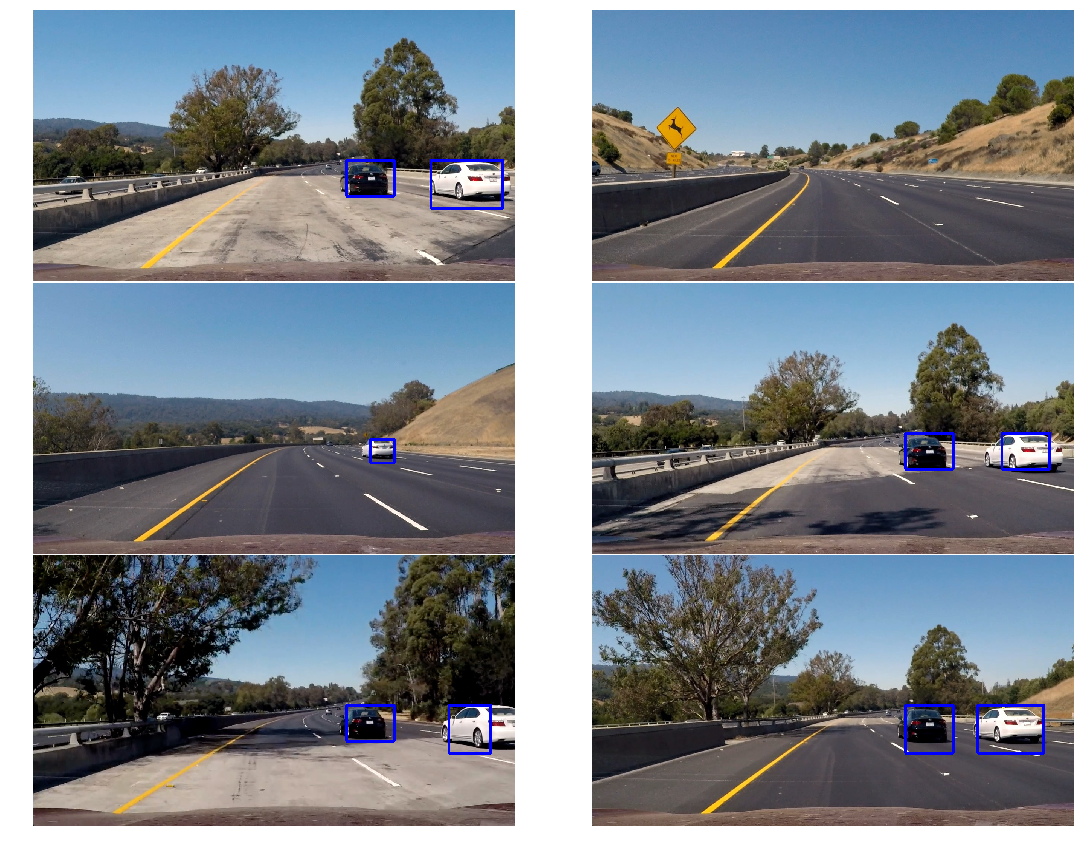

In [94]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(20,15))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(d.process_frame(mpimg.imread(im), video=False))
    axs[i].axis('off')


## 6.3. Test detecting cars on the test video

In [20]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
d.prev_rects = []
clip_test_out = clip_test.fl_image(d.process_frame)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:10<00:00,  3.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 11.4 s


# 7.0 Project video

In [21]:
out_file = 'project_video_out.mp4'
clip = VideoFileClip('project_video.mp4')
d.prev_rects = []
clip_out = clip.fl_image(d.process_frame)
%time clip_out.write_videofile(out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:08<00:00,  3.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 6min 9s
